<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/weibo_wmmBERT_testing_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

## 0-1 Install Dependences

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0-2 Parameters

In [2]:
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [3]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1 Load Dataset

## 1-1 Download ICI election dataset

In [4]:
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

File ‘df_sample.xlsx’ already there; not retrieving.



In [5]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['angry']=0 #neg
    ici_map_dict['anger']=0 #neg
    ici_map_dict['positive']=1 #pos
    ici_map_dict['posiitive']=1 #pos
    ici_map_dict['happy']=1 #pos
    ici_map_dict['neutral']=3 #ignore
    ici_map_dict['neural']=3 #ignore
    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['suprise']=3 #ignore
    ici_map_dict['sad']=0 #neg
    ici_map_dict['negative']=0 #neg
    ici_map_dict['fear']=0 #neg

len(ici_map_dict)

12

In [6]:
import pandas as pd

In [7]:
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text', 'sentiment']]
testing_pd = testing_pd.rename(columns={'sentiment':'label'})

# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(200, 2)

In [8]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
title_pattern = "[【|《*】|》]"

testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

In [9]:
len(testing_pd.iloc[0]['text'])

141

In [10]:
if number_classes == 2:
    from sklearn.utils import resample

    df_majority = testing_pd[testing_pd.label==1]
    df_minority = testing_pd[testing_pd.label==0]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df_majority.shape[0],    # to match majority class
                                    random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [11]:
num_label = len(testing_pd['label'].unique())
num_label

2

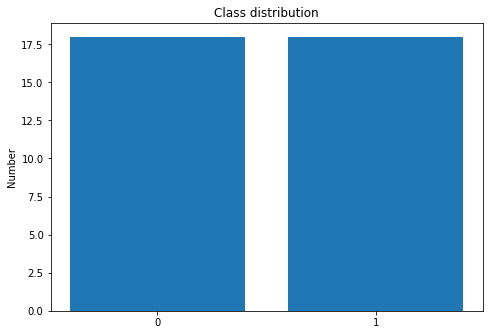

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(testing_pd['label'].unique(),
       testing_pd.groupby(['label']).count()['text'].tolist())

ax.set_xticks(testing_pd.groupby(['label']).count().index.values)

ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [13]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [14]:
from transformers import AutoTokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

In [16]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

## 2-1 Download ICI model

In [18]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

In [19]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


## 2-2 Get Accuracy

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [21]:
import numpy as np

# trainer.evaluate()

In [22]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 8


In [25]:
pred.metrics

{'test_loss': 0.5780361890792847,
 'test_accuracy': 0.8333333333333334,
 'test_runtime': 79.0436,
 'test_samples_per_second': 0.455,
 'test_steps_per_second': 0.063}

In [26]:
pred

PredictionOutput(predictions=array([[ 2.549473  , -1.7701553 ],
       [-1.321389  ,  0.9636757 ],
       [-1.3382366 ,  0.992024  ],
       [-1.3281672 ,  0.974887  ],
       [-1.3420908 ,  0.9987645 ],
       [-1.3446796 ,  1.0033622 ],
       [-1.3997698 ,  1.1446855 ],
       [ 0.4270216 , -0.90086627],
       [-1.3463022 ,  1.0062683 ],
       [-1.3366082 ,  0.9892082 ],
       [-1.3067622 ,  0.9401314 ],
       [-1.3436767 ,  1.0015757 ],
       [ 2.2496376 , -1.3744466 ],
       [-1.3467972 ,  1.0071635 ],
       [-1.3507669 ,  1.0143979 ],
       [-1.3415407 ,  0.9977976 ],
       [-1.3035315 ,  0.9350612 ],
       [ 2.4474597 , -1.5742104 ],
       [ 2.3350449 , -1.4602878 ],
       [ 2.5479627 , -1.7474123 ],
       [ 2.5478249 , -1.7899005 ],
       [ 0.65667546, -0.90292054],
       [ 2.5443463 , -1.7289728 ],
       [ 0.16388142, -0.760971  ],
       [ 0.1638814 , -0.76097107],
       [ 2.5327892 , -1.6954815 ],
       [-1.3092494 ,  0.9440684 ],
       [ 2.5419586 , -1.72

In [32]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [34]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [35]:
testing_pd

,text,label,pred
3,陈时中称蒋万安防疫主张抄袭自己 蒋万安：他防疫做得这么差 谁会想抄#台湾# 深圳卫视正午30...,1,0
8,港媒揭陈时中最新招数！预言“这情形”下：蒋万安稳当选九合一选举，台北市长选战成外界关注焦点！...,1,1
13,“都是将携手改变台北的战将”蒋万安出席4议员候选人竞总成立大会国民党台北市长候选人蒋万安，1...,1,1
19,虹安换万安？蒋万安：传闻大家都已听腻了年底选举脚步逼近，新竹传出要蓝白合“用高虹安换蒋万安”...,1,1
22,竞选节奏挨批躺平蒋万安：是奋战拼博到最后的战士国民党台北市长参选人蒋万安选战布局挨批龟速、躺...,1,1
24,蒋万安民调暂居第一 国民党：有信心一路领先最后胜选华夏经纬网8月1日讯：据台湾“联合新闻网”...,1,1
26,里长向黄珊珊喊冻蒜 蒋万安否认被拔桩：给候选人支持很正常年底台北市长“三脚督”底定，有意参战...,1,1
28,环南会长林胜东给“3字”评价 蒋万安：一直是好朋友台北市环南市场昨举办普度活动，各党派台北市...,1,0
32,看好蓝营北市长选情 连胜文：蒋万安是有温度、愿做事的帅哥国民党台北市长参选人蒋万安选情吃紧，...,1,1
33,爆周玉蔻与蒋万安决裂原因，徐巧芯：她以前动不动找蒋万安上节目 据台媒报道，台资深媒体人周玉...,1,1
